# Building Mixture Experimentalists

## Introduction

One thing the State should support is making more complex experimentalists which combine others.
One example that has been suggested by the `autora` group are a "mixture experimentalist," which weights the outputs of
other experimentalists.

How experimentalists are typically defined has a major impact on whether this kind of mixture experimentalist is easy
 or hard to implement. Since the research group is currently (August 2023) deciding how experimentalists should
 generally be defined, now seems a good time to look at the different basic options for standards & conventions.

To help the discussion, here we've put together some examples based on some toy experimentalists.

### Outline of the Open Question
The question has to do with whether "additional data" beyond the conditions are included in the same or a different
data array.
 ("Additional data" are data which are generated by the experimentalist and potentially needed by another
 experimentalist down the line, but are not the conditions themselves).

The two competing conventions are if an experimentalist returns some extra data:
- They are included in the `conditions` array as additional columns, _or_
- They are passed as a _different_ array alongside the `conditions`.

### Notebook Outline

The examples are organized as follows:

- A combination experimentalist which aggregates additional measures from the component experimentalists.
  - Where the measure is passed back in the conditions array, or
  - Where the measure is passed back in a separate array
- A combination experimentalist where the components need the full State  as they have complex arguments.


### Toy Experimentalists

We're combining experimentalists which samples conditions based on whether they are downvoted (or not)
according to some criteria:
- The `Avoid Negative` experimentalist, which downvotes conditions which have negative values (with one downvote per
negative value in the conditions $x_i$: if both $x_1$ and $x_2$ are negative, the condition gets 2 downvotes, and so
on) and returns all the conditions in the "preferred" order (fewest downvotes first),
- The `Avoid Even` experimentalist, which downvotes conditions which are closer to even numbers more (with one downvote
per even value in the conditions and half a downvote if a condition is $1/2$ away from an even number) and returns all the conditions in the "preferred" order,
- The `Avoid Repeat` experimentalist, which downvotes conditions which have already been seen based on the number of
times a condition has been seen and returns all the conditions in the "preferred" order,
- The `Combine Downvotes` experimentalist, which sums the downvotes of the others and returns the top $n$ "preferred"
conditions
(with the fewest downvotes); in the case of a tie, it returns conditions in the order of the original conditions list.


We also need to see what happens when we:
- Try to extend a dataframe with an extra data frame which has new columns.

## Combination Experimentalist which Aggregates Measures

### Returns an extended conditions array

In [ ]:
from typing import List, Optional

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from autora.variable import VariableCollection, Variable

In [ ]:
conditions_ = pd.DataFrame({"x1": np.linspace(-3, 3, 7), "x2": np.linspace(-1, 5, 7)})
conditions_

,x1,x2
0,-3.0,-1.0
1,-2.0,0.0
2,-1.0,1.0
3,0.0,2.0
4,1.0,3.0
5,2.0,4.0
6,3.0,5.0


In [ ]:
def avoid_negative(conditions: pd.DataFrame):
    downvotes = (conditions_ < 0).sum(axis=1)
    with_votes = pd.DataFrame.assign(conditions, downvotes=downvotes)
    with_votes_sorted = with_votes.sort_values(by="downvotes", ascending=True)
    return with_votes_sorted

avoid_negative(conditions_)

,x1,x2,downvotes
3,0.0,2.0,0
4,1.0,3.0,0
5,2.0,4.0,0
6,3.0,5.0,0
1,-2.0,0.0,1
2,-1.0,1.0,1
0,-3.0,-1.0,2


Text(0.5, 1.0, 'Avoid-even function')

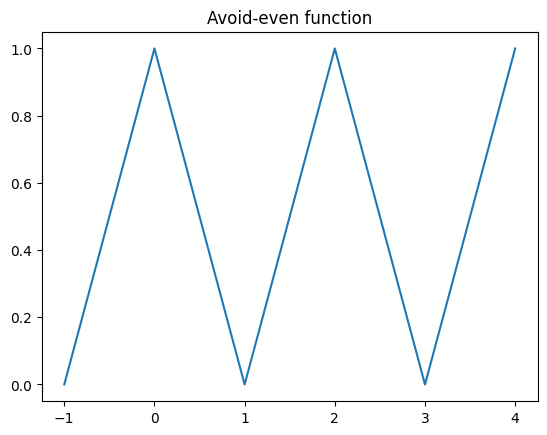

In [ ]:
def avoid_even_function(x):
    y = 1 - np.minimum(np.mod(x, 2), np.mod(-x, 2))
    return y

x = np.linspace(-1, 4, 101)
plt.plot(x, avoid_even_function(x))
plt.title("Avoid-even function")


In [ ]:
def avoid_even(conditions: pd.DataFrame):
    downvotes = avoid_even_function(conditions_).sum(axis=1)
    with_votes = pd.DataFrame.assign(conditions, downvotes=downvotes)
    with_votes_sorted = with_votes.sort_values(by="downvotes", ascending=True)
    return with_votes_sorted

avoid_even(conditions_)


,x1,x2,downvotes
0,-3.0,-1.0,0.0
2,-1.0,1.0,0.0
4,1.0,3.0,0.0
6,3.0,5.0,0.0
1,-2.0,0.0,2.0
3,0.0,2.0,2.0
5,2.0,4.0,2.0


In [ ]:
def combine_downvotes(conditions, *arrays: pd.DataFrame):
    result = conditions.copy()
    for i, a in enumerate(arrays):
        a_name = a.attrs.get("name", i)
        result[f"{a_name}.downvotes"] = a.downvotes
    result["downvotes"] = result.loc[:,result.columns.str.contains('.*\.downvotes')].sum(axis=1)
    return result

combine_downvotes(
    conditions_,
    conditions_.assign(downvotes=1),
    conditions_.assign(downvotes=[0, 1, 2, 3, 4, 5, 6]).sample(frac=1)
)

,x1,x2,0.downvotes,1.downvotes,downvotes
0,-3.0,-1.0,1,0,1
1,-2.0,0.0,1,1,2
2,-1.0,1.0,1,2,3
3,0.0,2.0,1,3,4
4,1.0,3.0,1,4,5
5,2.0,4.0,1,5,6
6,3.0,5.0,1,6,7


In [ ]:
def downvote_order(conditions: pd.DataFrame, experimentalists: List):
    downvoted_conditions = []
    for e in experimentalists:
        new_downvoted_conditions = e(conditions)
        new_downvoted_conditions.attrs["name"] = e.__name__
        downvoted_conditions.append(new_downvoted_conditions)
    result = combine_downvotes(conditions, *downvoted_conditions)
    result = result.sort_values(by="downvotes", ascending=True)
    return result

downvote_order(conditions_, experimentalists=[])

,x1,x2,downvotes
0,-3.0,-1.0,0.0
1,-2.0,0.0,0.0
2,-1.0,1.0,0.0
3,0.0,2.0,0.0
4,1.0,3.0,0.0
5,2.0,4.0,0.0
6,3.0,5.0,0.0


In [ ]:
downvote_order(conditions_, experimentalists=[avoid_negative])

,x1,x2,avoid_negative.downvotes,downvotes
3,0.0,2.0,0,0
4,1.0,3.0,0,0
5,2.0,4.0,0,0
6,3.0,5.0,0,0
1,-2.0,0.0,1,1
2,-1.0,1.0,1,1
0,-3.0,-1.0,2,2


In [ ]:
downvote_order(conditions_, experimentalists=[avoid_negative, avoid_even])


,x1,x2,avoid_negative.downvotes,avoid_even.downvotes,downvotes
4,1.0,3.0,0,0.0,0.0
6,3.0,5.0,0,0.0,0.0
2,-1.0,1.0,1,0.0,1.0
0,-3.0,-1.0,2,0.0,2.0
3,0.0,2.0,0,2.0,2.0
5,2.0,4.0,0,2.0,2.0
1,-2.0,0.0,1,2.0,3.0


Adding this dataframe to a State object:

In [ ]:
from autora.state import Delta, on_state, State, StandardState, inputs_from_state

s = StandardState() + Delta(conditions=downvote_order(conditions_, experimentalists=[avoid_negative, avoid_even]))
s.conditions

,x1,x2,avoid_negative.downvotes,avoid_even.downvotes,downvotes
4,1.0,3.0,0,0.0,0.0
6,3.0,5.0,0,0.0,0.0
2,-1.0,1.0,1,0.0,1.0
0,-3.0,-1.0,2,0.0,2.0
3,0.0,2.0,0,2.0,2.0
5,2.0,4.0,0,2.0,2.0
1,-2.0,0.0,1,2.0,3.0


### Return a separate array of additional measures

To ensure we don't mix up the order of return values and to facilitate updating the returned values in future without
 breaking dependents functions when returning multiple objects, we return a structured object –
in this case a simple dictionary of results.

In [ ]:
def avoid_negative_separate(conditions: pd.DataFrame):
    downvotes = (conditions_ < 0).sum(axis=1).sort_values(ascending=True)
    conditions_sorted = pd.DataFrame(conditions, index=downvotes.index)
    return {"conditions": conditions_sorted, "downvotes": downvotes}

avoid_negative_separate(conditions_)["conditions"]

,x1,x2
3,0.0,2.0
4,1.0,3.0
5,2.0,4.0
6,3.0,5.0
1,-2.0,0.0
2,-1.0,1.0
0,-3.0,-1.0


In [ ]:
def avoid_even_separate(conditions: pd.DataFrame):
    downvotes = avoid_even_function(conditions_).sum(axis=1).sort_values(ascending=True)
    conditions_sorted = pd.DataFrame(conditions, index=downvotes.index)
    return {"conditions": conditions_sorted, "downvotes": downvotes}

avoid_even_separate(conditions_)["conditions"], avoid_even_separate(conditions_)["downvotes"]

(    x1   x2
 0 -3.0 -1.0
 2 -1.0  1.0
 4  1.0  3.0
 6  3.0  5.0
 1 -2.0  0.0
 3  0.0  2.0
 5  2.0  4.0,
 0    0.0
 2    0.0
 4    0.0
 6    0.0
 1    2.0
 3    2.0
 5    2.0
 dtype: float64)

In [ ]:
def downvote_order_separate(conditions: pd.DataFrame, experimentalists: List):
    downvote_arrays = {"initial": pd.Series(0, index=conditions.index)}
    for e in experimentalists:
        downvote_arrays[e.__name__] = e(conditions)["downvotes"]
    combined_downvotes = pd.DataFrame(downvote_arrays)
    combined_downvotes["total"] = combined_downvotes.sum(axis=1)
    combined_downvotes_sorted = combined_downvotes.sort_values(by="total", ascending=True)
    conditions_sorted = pd.DataFrame(conditions, index=combined_downvotes_sorted.index)
    return {"conditions": conditions_sorted, "downvotes": combined_downvotes_sorted}

downvote_order_separate(conditions_, experimentalists=[])

{'conditions':     x1   x2
 0 -3.0 -1.0
 1 -2.0  0.0
 2 -1.0  1.0
 3  0.0  2.0
 4  1.0  3.0
 5  2.0  4.0
 6  3.0  5.0,
 'downvotes':    initial  total
 0        0      0
 1        0      0
 2        0      0
 3        0      0
 4        0      0
 5        0      0
 6        0      0}

In [ ]:
results = downvote_order_separate(conditions_, experimentalists=[avoid_even_separate, avoid_negative_separate])

pd.DataFrame.join(results["conditions"], results["downvotes"]).sort_index()

,x1,x2,initial,avoid_even_separate,avoid_negative_separate,total
0,-3.0,-1.0,0,0.0,2,2.0
1,-2.0,0.0,0,2.0,1,3.0
2,-1.0,1.0,0,0.0,1,1.0
3,0.0,2.0,0,2.0,0,2.0
4,1.0,3.0,0,0.0,0,0.0
5,2.0,4.0,0,2.0,0,2.0
6,3.0,5.0,0,0.0,0,0.0


## Combination Experimentalist Needing The Full State
In this case, we have at least one component-experimentalist which needs the full state.

### Experimentalists Return Combined Results and Measures

In [ ]:
def avoid_repeat(conditions, experiment_data: pd.DataFrame, variables: VariableCollection):
    iv_column_names = [v.name for v in variables.independent_variables]
    count_already_seen = pd.Series(experiment_data.groupby(iv_column_names).size(), name="downvotes")
    conditions = pd.DataFrame.join(conditions, count_already_seen, on=iv_column_names).fillna(0)
    return {"conditions": conditions, "already_seen": count_already_seen}

experiment_data_ = pd.DataFrame(dict(x1=[-3, 3, -3], x2=[-1, 5, -1]))
variables_ = VariableCollection(independent_variables=[Variable("x1"), Variable("x2")])

avoid_repeat(
    conditions=conditions_,
    experiment_data=experiment_data_,
    variables=variables_
)["conditions"]

,x1,x2,downvotes
0,-3.0,-1.0,2.0
1,-2.0,0.0,0.0
2,-1.0,1.0,0.0
3,0.0,2.0,0.0
4,1.0,3.0,0.0
5,2.0,4.0,0.0
6,3.0,5.0,1.0


We wrap the `avoid_repeat` function with the usual `on_state` wrapper to make it compatible with the state mechanism.
 As it already returns a dictionary, we don't need to specify the output names.
 Then we can the wrapped function on the State object.

In [ ]:
avoid_repeat_state = on_state(avoid_repeat)
s = StandardState(
    experiment_data=pd.DataFrame(dict(x1=[-3, 3, -3], x2=[-1, 5, -1])),
    variables=VariableCollection(independent_variables=[Variable("x1"), Variable("x2")])
)
avoid_repeat_state(s, conditions=conditions_)

c:\Users\cwill\GitHub\virtualEnvs\autoraEnv\lib\site-packages\autora\state.py:249: UserWarning: These fields: ['already_seen'] could not be used to update StandardState, which has these fields & aliases: ['variables', 'conditions', 'experiment_data', 'models']
  warnings.warn(


StandardState(variables=VariableCollection(independent_variables=[Variable(name='x1', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False), Variable(name='x2', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[], covariates=[]), conditions=    x1   x2  downvotes
0 -3.0 -1.0        2.0
1 -2.0  0.0        0.0
2 -1.0  1.0        0.0
3  0.0  2.0        0.0
4  1.0  3.0        0.0
5  2.0  4.0        0.0
6  3.0  5.0        1.0, experiment_data=   x1  x2
0  -3  -1
1   3   5
2  -3  -1, models=[])

The way we handle this is to write a function which operates on the State directly, passing it to
experimentalists wrapped with `on_state`, then combine their outputs.
This is done as follows if our conditions are returned with the downvotes in the same dataframe:

In [ ]:
@on_state()
def combine_downvotes_state(
    state: State,
    conditions: pd.DataFrame,
    experimentalists: List,
    num_samples: int
):
    # iv_column_names = [v.name for v in s.variables.independent_variables]
    downvoted_conditions = []
    for e in experimentalists:
        new_state = e(state, conditions=conditions)
        this_downvoted_conditions = new_state.conditions
        this_downvoted_conditions.attrs["name"] = e.__name__
        downvoted_conditions.append(this_downvoted_conditions)
    combined_downvotes = combine_downvotes(conditions, *downvoted_conditions)
    combined_downvotes_sorted_filtered = combined_downvotes\
        .sort_values(by="downvotes", ascending=True)\
        .iloc[:num_samples]

    d = Delta(conditions=combined_downvotes_sorted_filtered)
    return d

combine_downvotes_state(
    s,
    conditions=conditions_,
    experimentalists=[
        on_state(avoid_repeat),
        on_state(avoid_negative, output=["conditions"]),
        on_state(avoid_even, output=["conditions"])
    ],
    num_samples=7
).conditions

c:\Users\cwill\GitHub\virtualEnvs\autoraEnv\lib\site-packages\autora\state.py:249: UserWarning: These fields: ['already_seen'] could not be used to update StandardState, which has these fields & aliases: ['variables', 'conditions', 'experiment_data', 'models']
  warnings.warn(


TypeError: 'str' object is not callable

### Experimentalists Return Separate Conditions and Additional Measures

If we return separate conditions and measures, then we need to split up the
combined downvoted conditions from the downvotes:

In [ ]:
def avoid_repeat_separate(
    conditions: pd.DataFrame,
    experiment_data: pd.DataFrame,
    variables: VariableCollection
):
    conditions_with_downvotes = avoid_repeat(
        conditions=conditions,
        experiment_data=experiment_data,
        variables=variables
    )["conditions"]

    # Now we split up the results
    iv_column_names = [v.name for v in variables.independent_variables]
    conditions = conditions_with_downvotes[iv_column_names]
    downvotes = conditions_with_downvotes["downvotes"]

    return {"conditions": conditions, "downvotes": downvotes}

avoid_repeat_separate(
    conditions=conditions_,
    experiment_data=experiment_data_,
    variables=variables_
)

{'conditions':     x1   x2
 0 -3.0 -1.0
 1 -2.0  0.0
 2 -1.0  1.0
 3  0.0  2.0
 4  1.0  3.0
 5  2.0  4.0
 6  3.0  5.0,
 'downvotes': 0    2.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 5    0.0
 6    1.0
 Name: downvotes, dtype: float64}

In the aggregation function, we have to gather the "downvotes" from the individual experimentalists
(having passed them the full state as well as some seed conditions), then combine them,
before we can split off the conditions and downvotes for the result object

In [ ]:
@on_state()
def combine_downvotes_separate_state(
    state: State,
    conditions: pd.DataFrame,
    experimentalists: List,
    variables: VariableCollection,
    num_samples: int
):
    # iv_column_names = [v.name for v in s.variables.independent_variables]
    all_downvotes = []
    for e in experimentalists:
        delta = e(state, conditions=conditions)
        this_downvotes_series = delta["downvotes"]
        this_downvotes_series.attrs["name"] = e.__name__
        all_downvotes.append(this_downvotes_series.to_frame("downvotes"))
    combined_downvotes = combine_downvotes(conditions, *all_downvotes)

    combined_downvotes_sorted_filtered = combined_downvotes\
        .sort_values(by="downvotes", ascending=True)\
        .iloc[:num_samples]

    iv_column_names = [v.name for v in variables.independent_variables]
    result_conditions = combined_downvotes_sorted_filtered[iv_column_names]
    result_downvotes = combined_downvotes_sorted_filtered["downvotes"]

    d = Delta(conditions=result_conditions, downvotes=result_downvotes)
    return d

combine_downvotes_separate_state(
    s,
    conditions=conditions_,
    experimentalists=[
        # Here we have to use `inputs_from_state` but return our dictionary.
        # There isn't a `downvotes` field we can update,
        # so if we try to use the state mechanism, we lose the downvotes data
        inputs_from_state(avoid_repeat_separate),
        inputs_from_state(avoid_negative_separate),
        inputs_from_state(avoid_even_separate)
    ],
    num_samples=7
).conditions

c:\Users\cwill\GitHub\virtualEnvs\autoraEnv\lib\site-packages\autora\state.py:249: UserWarning: These fields: ['downvotes'] could not be used to update StandardState, which has these fields & aliases: ['variables', 'conditions', 'experiment_data', 'models']
  warnings.warn(


,x1,x2
4,1.0,3.0
2,-1.0,1.0
6,3.0,5.0
3,0.0,2.0
5,2.0,4.0
1,-2.0,0.0
0,-3.0,-1.0


### Chained Experimentalists
We can also define experimentalists which add their vote to the existing vote, if it exists:

In [ ]:
def combine_downvotes(a, b, *arrays):
    if isinstance(b, pd.Series):
        new_downvotes = b
    elif isinstance(b, pd.DataFrame):
        new_downvotes = b.downvotes
    if "downvotes" in a.columns:
        result = a.assign(downvotes=a.downvotes + new_downvotes)
    else:
        result = a.assign(downvotes=new_downvotes)
    if len(arrays) == 0:
        return result
    else:
        return combine_downvotes(result, arrays[0], *arrays[1:])

If we pass in some conditions with no downvotes (`conditions_`)
and then combine with a DataFrame with constant downvotes `conditions_.assign(downvotes=1)`
we get constant total downvotes:

In [ ]:
combine_downvotes(
    conditions_,
    conditions_.assign(downvotes=1)
)

,x1,x2,downvotes
0,-3.0,-1.0,1
1,-2.0,0.0,1
2,-1.0,1.0,1
3,0.0,2.0,1
4,1.0,3.0,1
5,2.0,4.0,1
6,3.0,5.0,1


We can add another set of downvotes, which are summed with the existing ones:

In [ ]:
combine_downvotes(
    conditions_,
    conditions_.assign(downvotes=1),
    conditions_.assign(downvotes=[0, 1, 2, 3, 4, 5, 6]).sample(frac=1)
)

,x1,x2,downvotes
0,-3.0,-1.0,1
1,-2.0,0.0,2
2,-1.0,1.0,3
3,0.0,2.0,4
4,1.0,3.0,5
5,2.0,4.0,6
6,3.0,5.0,7


Using these, we can build functions which are aware of and add to existing downvotes if they exist.

In [ ]:
@on_state()
def avoid_even_chainable(conditions: pd.DataFrame, variables: VariableCollection):
    iv_names = [v.name for v in variables.independent_variables]
    downvotes = avoid_even_function(conditions_[iv_names]).sum(axis=1)
    result = combine_downvotes(conditions, downvotes)
    result["avoid_even.downvotes"] = downvotes
    return {"conditions": result}
avoid_even_chainable(s, conditions=conditions_)

StandardState(variables=VariableCollection(independent_variables=[Variable(name='x1', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False), Variable(name='x2', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[], covariates=[]), conditions=    x1   x2  downvotes  avoid_even.downvotes
0 -3.0 -1.0        0.0                   0.0
1 -2.0  0.0        2.0                   2.0
2 -1.0  1.0        0.0                   0.0
3  0.0  2.0        2.0                   2.0
4  1.0  3.0        0.0                   0.0
5  2.0  4.0        2.0                   2.0
6  3.0  5.0        0.0                   0.0, experiment_data=   x1  x2
0  -3  -1
1   3   5
2  -3  -1, models=[])

In [ ]:
@on_state()
def avoid_negative_chainable(conditions: pd.DataFrame, variables: VariableCollection):
    iv_names = [v.name for v in variables.independent_variables]
    downvotes = (conditions_[iv_names] < 0).sum(axis=1)
    result = combine_downvotes(conditions, downvotes)
    result["avoid_negative.downvotes"] = downvotes
    return {"conditions": result}
avoid_negative_chainable(s, conditions=conditions_)

StandardState(variables=VariableCollection(independent_variables=[Variable(name='x1', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False), Variable(name='x2', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[], covariates=[]), conditions=    x1   x2  downvotes  avoid_negative.downvotes
0 -3.0 -1.0          2                         2
1 -2.0  0.0          1                         1
2 -1.0  1.0          1                         1
3  0.0  2.0          0                         0
4  1.0  3.0          0                         0
5  2.0  4.0          0                         0
6  3.0  5.0          0                         0, experiment_data=   x1  x2
0  -3  -1
1   3   5
2  -3  -1, models=[])

In [ ]:
@on_state()
def avoid_repeat_chainable(
    conditions: pd.DataFrame,
    experiment_data: pd.DataFrame,
    variables: VariableCollection
):
    iv_column_names = [v.name for v in variables.independent_variables]
    count_already_seen = pd.Series(experiment_data.groupby(iv_column_names).size(), name="downvotes")
    downvotes = pd.DataFrame.join(conditions, count_already_seen, on=iv_column_names).fillna(0)["downvotes"]
    result = combine_downvotes(conditions, downvotes)
    result["avoid_repeat.downvotes"] = downvotes
    return {"conditions": result}


avoid_repeat_chainable(
    s, conditions=conditions_
)

StandardState(variables=VariableCollection(independent_variables=[Variable(name='x1', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False), Variable(name='x2', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[], covariates=[]), conditions=    x1   x2  downvotes  avoid_repeat.downvotes
0 -3.0 -1.0        2.0                     2.0
1 -2.0  0.0        0.0                     0.0
2 -1.0  1.0        0.0                     0.0
3  0.0  2.0        0.0                     0.0
4  1.0  3.0        0.0                     0.0
5  2.0  4.0        0.0                     0.0
6  3.0  5.0        1.0                     1.0, experiment_data=   x1  x2
0  -3  -1
1   3   5
2  -3  -1, models=[])

In [ ]:
@on_state()
def sample_downvotes(conditions: pd.DataFrame, num_samples:Optional[int]=None):
    conditions = conditions.sort_values(by="downvotes").iloc[:num_samples]
    return Delta(conditions=conditions)

sample_downvotes(
    avoid_repeat_chainable(s, conditions=conditions_),
    num_samples=6
).conditions


,x1,x2,downvotes,avoid_repeat.downvotes
1,-2.0,0.0,0.0,0.0
2,-1.0,1.0,0.0,0.0
3,0.0,2.0,0.0,0.0
4,1.0,3.0,0.0,0.0
5,2.0,4.0,0.0,0.0
6,3.0,5.0,1.0,1.0


In [ ]:
s_0 = s + Delta(conditions=conditions_)  # add the seed conditions
s_1 = avoid_repeat_chainable(s_0)
s_2 = avoid_even_chainable(s_1)
s_3 = avoid_negative_chainable(s_2)
s_4 = sample_downvotes(s_3, num_samples=7)
s_4.conditions

,x1,x2,downvotes,avoid_repeat.downvotes,avoid_even.downvotes,avoid_negative.downvotes
4,1.0,3.0,0.0,0.0,0.0,0
2,-1.0,1.0,1.0,0.0,0.0,1
6,3.0,5.0,1.0,1.0,0.0,0
3,0.0,2.0,2.0,0.0,2.0,0
5,2.0,4.0,2.0,0.0,2.0,0
1,-2.0,0.0,3.0,0.0,2.0,1
0,-3.0,-1.0,4.0,2.0,0.0,2


## What Happens When We Extend a Dataframe With New Columns in the State Mechanism
If we have an experiment_data field which has particular columns:

In [ ]:
s_0 = StandardState(
    experiment_data=pd.DataFrame({"x1":[-10], "x2":[-10], "y":[-10]})
)

... and we add data with extra columns:

In [ ]:
new_experiment_data = pd.DataFrame({"x1":[5], "x2":[5], "y":[5], "new_column": [15]})
s_1 = s_0 + Delta(experiment_data=new_experiment_data)

 then the additional columns just
get added on the end, and any missing values are replaced by NaNs:

In [ ]:
s_1.experiment_data

,x1,x2,y,new_column
0,-10,-10,-10,NaN
1,5,5,5,15.0
